In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import cv2 as cv

from keras.layers import Conv2D, Input, LeakyReLU, Dense, Activation, Flatten, Dropout, MaxPool2D
from keras import models
from keras.optimizers import Adam,RMSprop 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import pickle

%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(1)
df_train = pd.read_csv("mnist_train.csv")
df_train = df_train.iloc[np.random.permutation(len(df_train))]

In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
29633,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
345,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36369,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16624,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14389,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_train.shape

(42000, 785)

In [5]:
sample_size = df_train.shape[0]    # Training set size
validation_size = int(df_train.shape[0]*0.1)   #  Validation set size



train_x = np.asarray(df_train.iloc[:sample_size-validation_size,1:]).reshape([sample_size-validation_size,28,28,1])
train_y = np.asarray(df_train.iloc[:sample_size-validation_size,0]).reshape([sample_size-validation_size,1])

val_x = np.asarray(df_train.iloc[sample_size-validation_size:,1:]).reshape([validation_size,28,28,1])
val_y = np.asarray(df_train.iloc[sample_size-validation_size:,0]).reshape([validation_size,1])


In [6]:
train_x.shape,train_y.shape

((37800, 28, 28, 1), (37800, 1))

In [7]:
val_x.shape,val_y.shape

((4200, 28, 28, 1), (4200, 1))

In [8]:
df_test = pd.read_csv("mnist_test.csv")
test_x = np.asarray(df_test.iloc[:,:]).reshape([-1,28,28,1])

In [9]:
test_x.shape

(28000, 28, 28, 1)

In [10]:
# normalize pixel data
train_x = train_x/255
val_x = val_x/255
test_x = test_x/255

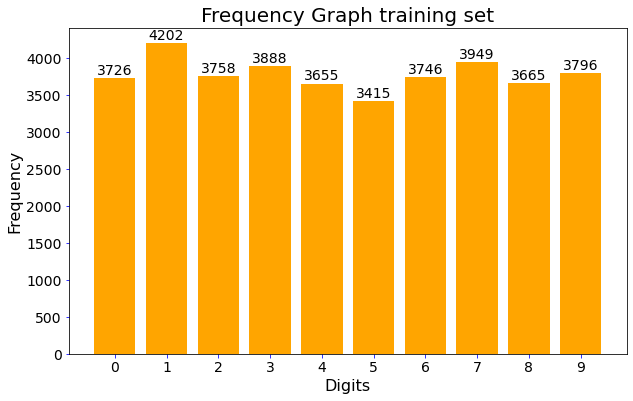

In [11]:
# Checking frequency of digits in training and validation set
counts = df_train.iloc[:sample_size-validation_size,:].groupby('label')['label'].count()

f = plt.figure(figsize=(10,6))
f.add_subplot(111)

plt.bar(counts.index,counts.values,width=0.8,color="orange")
for i in counts.index:
    plt.text(i,counts.values[i]+50,str(counts.values[i]),horizontalalignment='center',fontsize=14)

plt.tick_params(labelsize=14,color='b')
plt.xticks(counts.index)
plt.xlabel('Digits',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.title("Frequency Graph training set",fontsize=20)
plt.savefig('digit_frequency_train.png')
plt.show()

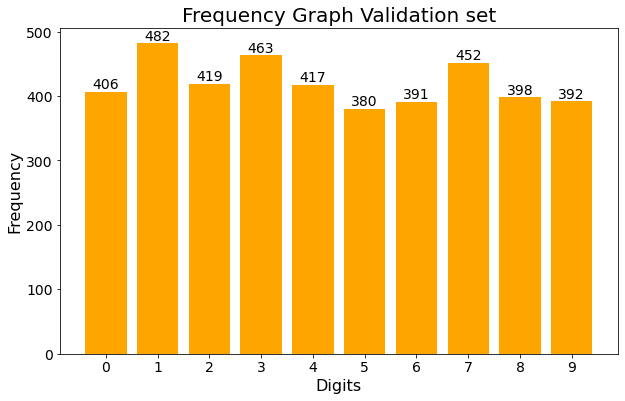

In [12]:
# Cheacking frequency of digits in training and validation set
counts = df_train.iloc[sample_size-validation_size:,:].groupby('label')['label'].count()
# df_train.head(2)
# counts
f = plt.figure(figsize=(10,6))
f.add_subplot(111)

plt.bar(counts.index,counts.values,width = 0.8,color="orange")
for i in counts.index:
    plt.text(i,counts.values[i]+5,str(counts.values[i]),horizontalalignment='center',fontsize=14)

plt.tick_params(labelsize = 14)
plt.xticks(counts.index)
plt.xlabel("Digits",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title("Frequency Graph Validation set",fontsize=20)
plt.savefig('digit_frequency_val.png')
plt.show()

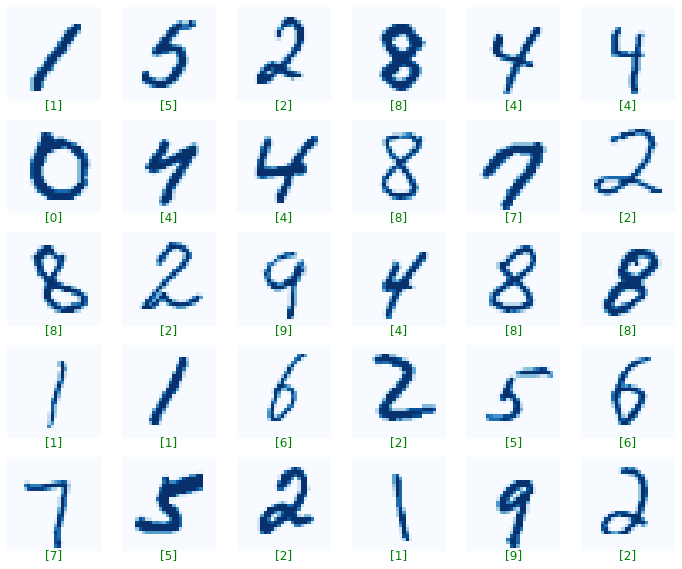

In [13]:
rows = 5 # defining no. of rows in figure
cols = 6 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows)) # defining a figure 

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.imshow(train_x[i].reshape([28,28]),cmap="Blues") 
    plt.axis("off")
    plt.title(str(train_y[i]), y=-0.15,color="green")
plt.savefig("digits.png")

In [14]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [15]:
model = models.Sequential()

In [16]:
#Block 1
model.add(Conv2D(32,3,padding="same",input_shape=(28,28,1)))
model.add(LeakyReLU())
model.add(Conv2D(32,3,padding="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Block 2
model.add(Conv2D(64,3,padding="same"))
model.add(LeakyReLU())
model.add(Conv2D(64,3,padding="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation='sigmoid'))

In [17]:
initial_lr = 0.001
loss = "sparse_categorical_crossentropy"
model.compile(Adam(lr=initial_lr), loss=loss ,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)       

In [18]:
epochs = 20
batch_size = 256
history_1 = model.fit(train_x,train_y,batch_size=batch_size,epochs=epochs,validation_data=[val_x,val_y])

Train on 37800 samples, validate on 4200 samples
Epoch 1/20
37800/37800 [==============================] - 24s 622us/step - loss: 0.4350 - accuracy: 0.8644 - val_loss: 0.1211 - val_accuracy: 0.9643
Epoch 2/20
37800/37800 [==============================] - 19s 497us/step - loss: 0.0895 - accuracy: 0.9730 - val_loss: 0.0866 - val_accuracy: 0.9721
Epoch 3/20
37800/37800 [==============================] - 18s 468us/step - loss: 0.0605 - accuracy: 0.9816 - val_loss: 0.0588 - val_accuracy: 0.9810
Epoch 4/20
37800/37800 [==============================] - 18s 475us/step - loss: 0.0474 - accuracy: 0.9845 - val_loss: 0.0492 - val_accuracy: 0.9836
Epoch 5/20
37800/37800 [==============================] - 19s 493us/step - loss: 0.0387 - accuracy: 0.9876 - val_loss: 0.0597 - val_accuracy: 0.9824
Epoch 6/20
37800/37800 [==============================] - 18s 484us/step - loss: 0.0313 - accuracy: 0.9898 - val_loss: 0.0473 - val_accuracy: 0.9860
Epoch 7/20
37800/37800 [==============================] -

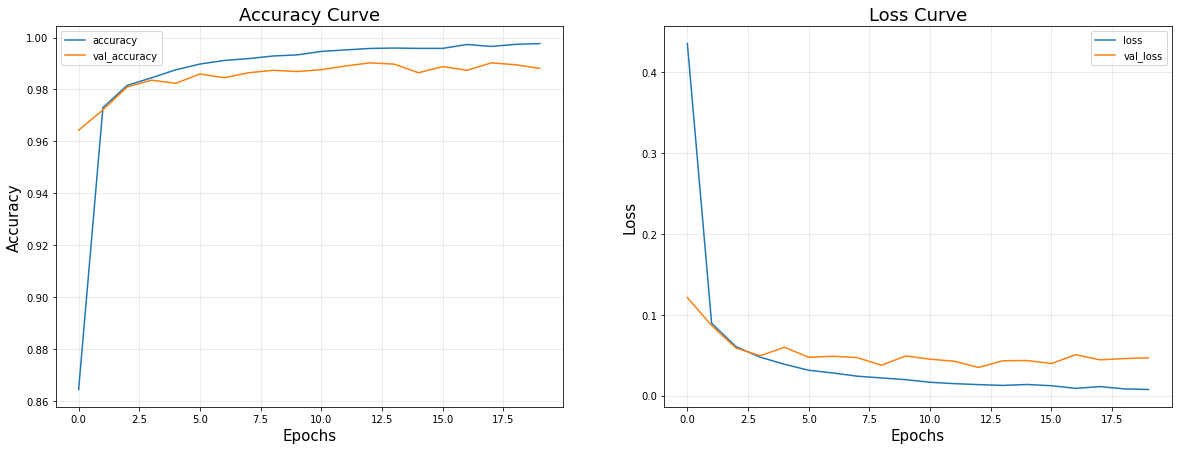

In [19]:
# Diffining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(history_1.epoch,history_1.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history_1.epoch,history_1.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(history_1.epoch,history_1.history['loss'],label="loss") # Loss curve for training set
plt.plot(history_1.epoch,history_1.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [20]:
val_p = np.argmax(model.predict(val_x),axis =1)

error = 0
confusion_matrix = np.zeros([10,10])
for i in range(val_x.shape[0]):
    confusion_matrix[val_y[i],val_p[i]] += 1
    if val_y[i]!=val_p[i]:
        error +=1
        
print("Confusion Matrix: \n\n" ,confusion_matrix)
print("\nErrors in validation set: " ,error)
print("\nError Persentage : " ,(error*100)/val_p.shape[0])
print("\nAccuracy : " ,100-(error*100)/val_p.shape[0])
print("\nValidation set Shape :",val_p.shape[0])

Confusion Matrix: 

 [[403.   0.   0.   0.   0.   0.   2.   0.   0.   1.]
 [  0. 477.   1.   0.   0.   1.   1.   2.   0.   0.]
 [  0.   0. 416.   0.   0.   0.   0.   2.   1.   0.]
 [  0.   0.   2. 459.   0.   0.   0.   0.   1.   1.]
 [  0.   1.   1.   0. 402.   0.   4.   0.   1.   8.]
 [  0.   0.   0.   0.   0. 375.   0.   0.   0.   5.]
 [  0.   0.   1.   0.   1.   1. 388.   0.   0.   0.]
 [  0.   0.   3.   0.   0.   0.   0. 448.   0.   1.]
 [  1.   1.   1.   0.   0.   0.   0.   0. 395.   0.]
 [  1.   0.   0.   0.   1.   1.   0.   2.   0. 387.]]

Errors in validation set:  50

Error Persentage :  1.1904761904761905

Accuracy :  98.80952380952381

Validation set Shape : 4200


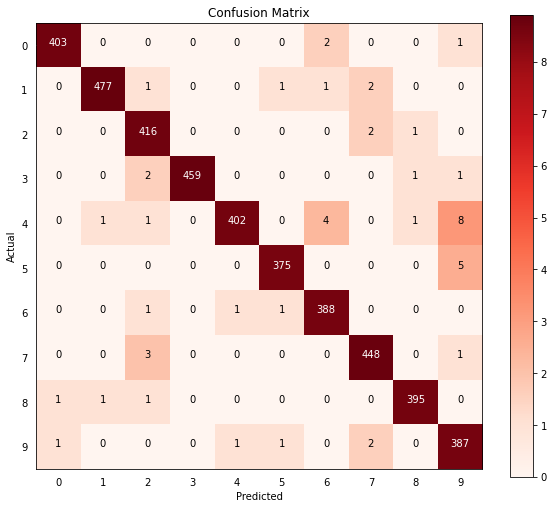

In [21]:
f = plt.figure(figsize=(10,8.5))
f.add_subplot(111)

plt.imshow(np.log2(confusion_matrix+1),cmap="Reds")
plt.colorbar()
plt.tick_params(size=5,color="white")
plt.xticks(np.arange(0,10),np.arange(0,10))
plt.yticks(np.arange(0,10),np.arange(0,10))

threshold = confusion_matrix.max()/2 

for i in range(10):
    for j in range(10):
        plt.text(j,i,int(confusion_matrix[i,j]),horizontalalignment="center",color="white" if confusion_matrix[i, j] > threshold else "black")
        
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion_matrix1.png")
plt.show()

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(train_x)

In [23]:
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.00001)

In [24]:
epochs = 20
history_2 = model.fwhit_generator(datagen.flow(train_x,train_y, batch_size=batch_size),steps_per_epoch=int(train_x.shape[0]/batch_size)+1,epochs=epochs,validation_data=[val_x,val_y],callbacks=[lrr])

Epoch 1/20
148/148 [==============================] - 31s 208ms/step - loss: 0.1363 - accuracy: 0.9615 - val_loss: 0.0352 - val_accuracy: 0.9895
Epoch 2/20
148/148 [==============================] - 36s 241ms/step - loss: 0.0652 - accuracy: 0.9795 - val_loss: 0.0381 - val_accuracy: 0.9886
Epoch 3/20
148/148 [==============================] - 35s 239ms/step - loss: 0.0563 - accuracy: 0.9833 - val_loss: 0.0359 - val_accuracy: 0.9890

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
148/148 [==============================] - 36s 242ms/step - loss: 0.0396 - accuracy: 0.9876 - val_loss: 0.0258 - val_accuracy: 0.9924
Epoch 5/20
148/148 [==============================] - 35s 236ms/step - loss: 0.0366 - accuracy: 0.9885 - val_loss: 0.0222 - val_accuracy: 0.9955
Epoch 6/20
148/148 [==============================] - 36s 242ms/step - loss: 0.0329 - accuracy: 0.9898 - val_loss: 0.0244 - val_accuracy: 0.9929
Epoch 7/20
148/148 [=============================

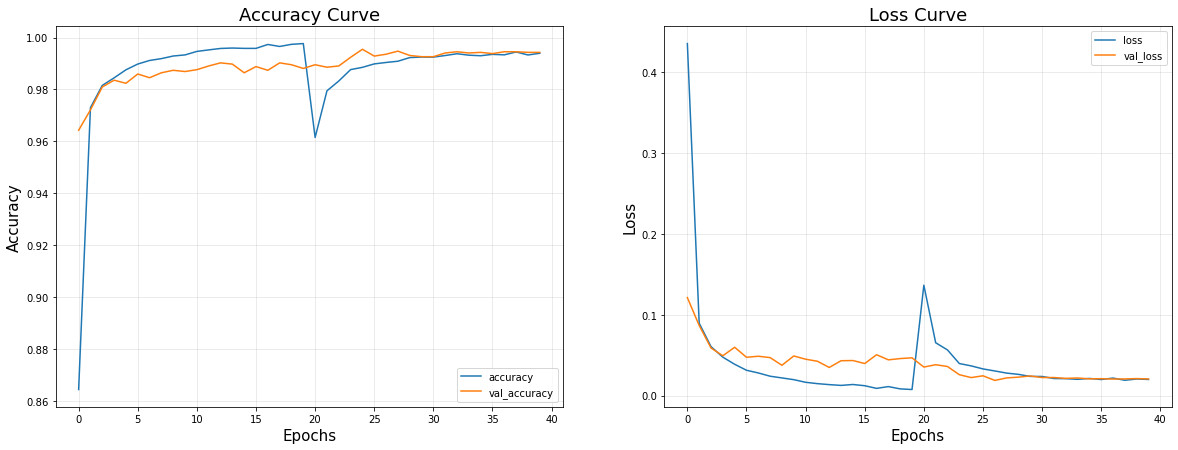

In [25]:
# Diffining Figure
f = plt.figure(figsize=(20,7))
f.add_subplot(121)

#Adding Subplot 1 (For Accuracy)
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['accuracy']+history_2.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['val_accuracy']+history_2.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['loss']+history_2.history['loss'],label="loss") # Loss curve for training set
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['val_loss']+history_2.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [26]:
val_p = np.argmax(model.predict(val_x),axis =1)

error = 0
confusion_matrix = np.zeros([10,10])
for i in range(val_x.shape[0]):
    confusion_matrix[val_y[i],val_p[i]] += 1
    if val_y[i]!=val_p[i]:
        error +=1
        
confusion_matrix,error,(error*100)/val_p.shape[0],100-(error*100)/val_p.shape[0],val_p.shape[0]

print("Confusion Matrix: \n\n" ,confusion_matrix)
print("\nErrors in validation set: " ,error)
print("\nError Persentage : " ,(error*100)/val_p.shape[0])
print("\nAccuracy : " ,100-(error*100)/val_p.shape[0])
print("\nValidation set Shape :",val_p.shape[0])

Confusion Matrix: 

 [[405.   0.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  0. 478.   0.   0.   0.   0.   0.   4.   0.   0.]
 [  0.   0. 416.   1.   0.   0.   0.   1.   1.   0.]
 [  0.   0.   1. 461.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0. 414.   0.   1.   0.   1.   1.]
 [  0.   0.   0.   0.   0. 379.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   1.   0. 389.   0.   1.   0.]
 [  0.   0.   2.   0.   1.   0.   0. 448.   0.   1.]
 [  0.   0.   1.   0.   0.   0.   0.   0. 397.   0.]
 [  0.   0.   0.   0.   2.   1.   0.   0.   0. 389.]]

Errors in validation set:  24

Error Persentage :  0.5714285714285714

Accuracy :  99.42857142857143

Validation set Shape : 4200


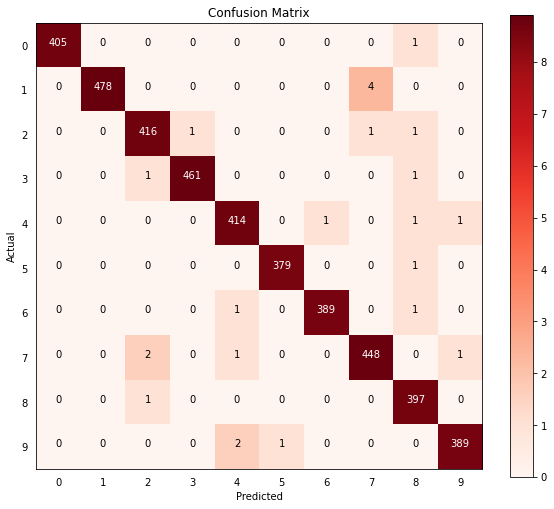

In [27]:
f = plt.figure(figsize=(10,8.5))
f.add_subplot(111)

plt.imshow(np.log2(confusion_matrix+1),cmap="Reds")
plt.colorbar()
plt.tick_params(size=5,color="white")
plt.xticks(np.arange(0,10),np.arange(0,10))
plt.yticks(np.arange(0,10),np.arange(0,10))

threshold = confusion_matrix.max()/2 

for i in range(10):
    for j in range(10):
        plt.text(j,i,int(confusion_matrix[i,j]),horizontalalignment="center",color="white" if confusion_matrix[i, j] > threshold else "black")
        
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion_matrix2.png")
plt.show()

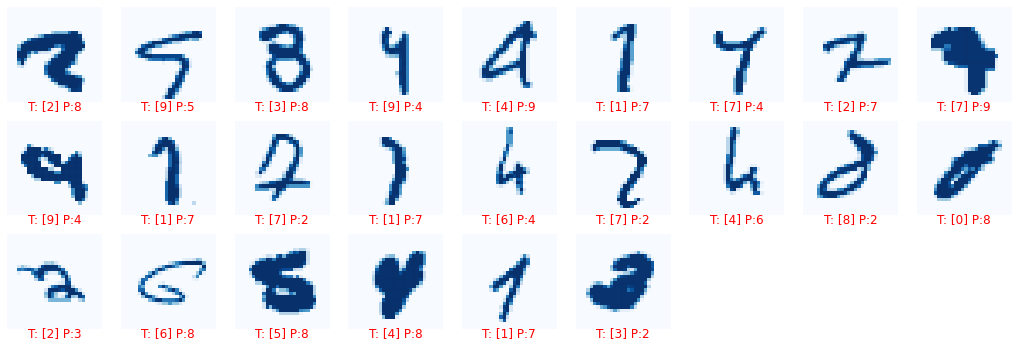

In [28]:
rows = 4
cols = 9

f = plt.figure(figsize=(2*cols,2*rows))
sub_plot = 1
for i in range(val_x.shape[0]):
    if val_y[i]!=val_p[i]:
        f.add_subplot(rows,cols,sub_plot) 
        sub_plot+=1
        plt.imshow(val_x[i].reshape([28,28]),cmap="Blues")
        plt.axis("off")
        plt.title("T: "+str(val_y[i])+" P:"+str(val_p[i]), y=-0.15,color="Red")
plt.savefig("error_plots.png")
plt.show()

In [29]:
test_y = np.argmax(model.predict(test_x),axis =1)

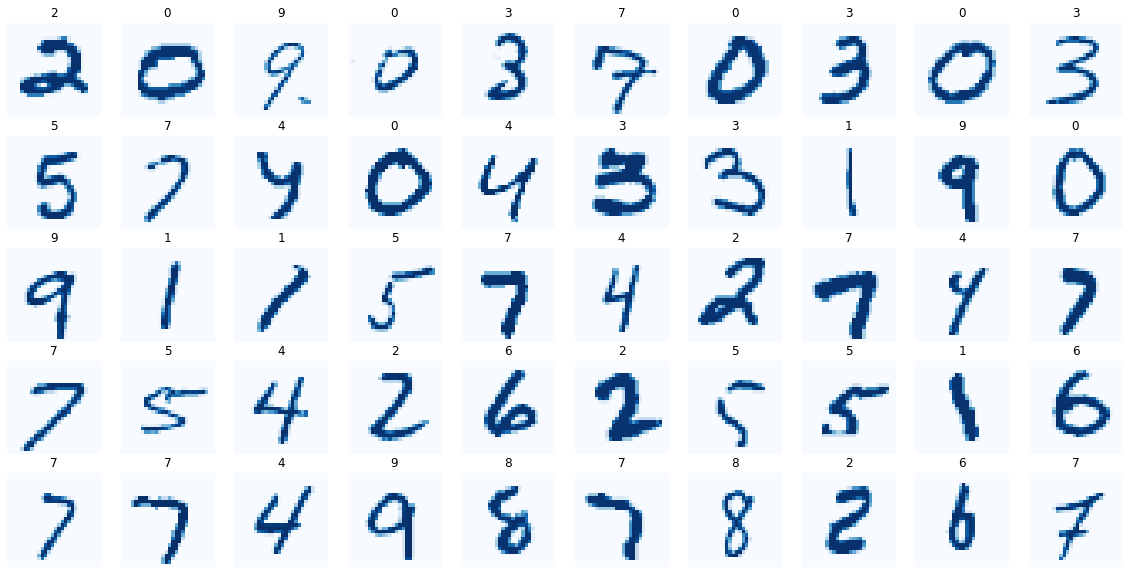

In [30]:
rows = 5
cols = 10

f = plt.figure(figsize=(2*cols,2*rows))

for i in range(rows*cols):
    f.add_subplot(rows,cols,i+1)
    plt.imshow(test_x[i].reshape([28,28]),cmap="Blues")
    plt.axis("off")
    plt.title(str(test_y[i]))

In [31]:
# Extracts the outputs of all layers except Flatten and Dense layers
output_layers = [layer.output for layer in model.layers[:-4]]
# Creates a model that will return these outputs, given the model input (This is multi output model)
activation_model = models.Model(inputs=model.input, outputs=output_layers)

In [32]:
# predicting the output of each layers
activations_2  = activation_model.predict(val_x[2].reshape([1,28,28,1]))
activations_6  = activation_model.predict(val_x[7].reshape([1,28,28,1]))
first_activation_layer  = activations_2[0]
first_activation_layer.shape

(1, 28, 28, 32)

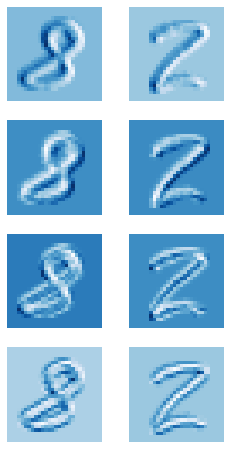

In [33]:
rows = 4
cols = 2

f = plt.figure(figsize=(2*cols,2*rows))

for i in range(4):
    f.add_subplot(rows,cols,2*i+1)
    plt.imshow(activations_2[0][0,:,:,i].reshape([28,28]),cmap="Blues")
    plt.axis("off") 

    f.add_subplot(rows,cols,2*i+2)
    plt.imshow(activations_6[0][0,:,:,i].reshape([28,28]),cmap="Blues")
    plt.savefig("layer_output_comparision"+str(i)+".png")
    plt.axis("off")

In [34]:
def plot_layer(layer,i,layer_name = None):
    rows = layer.shape[-1]/16
    cols = 16

    f = plt.figure(figsize=(1*cols,1*rows))
    # plt.imshow(first_activation_layer[0,:,:,:].reshape([14*4,14*16]),cmap="Blues")
    for i in range(layer.shape[-1]):
        f.add_subplot(rows,cols,i+1)
        plt.imshow(layer[0,:,:,i].reshape([layer.shape[2],layer.shape[2]]),cmap="Blues")
        plt.axis("off")
    f.suptitle(layer_name,fontsize=14)
    plt.savefig("intermidiate_layers"+str(i)+".png")
    plt.show()

G:\anaconda\envs\virspace\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


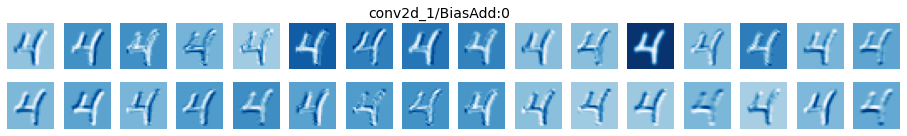

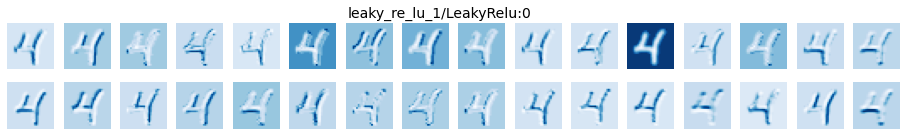

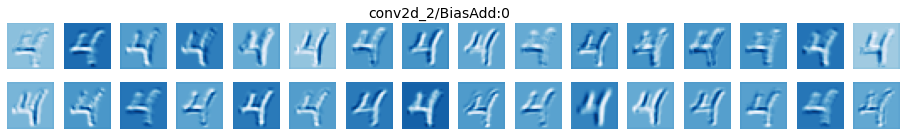

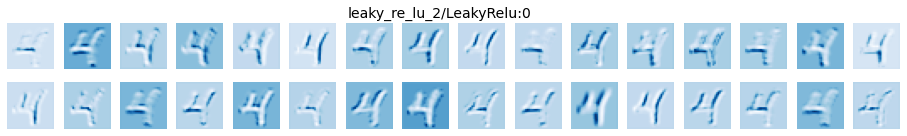

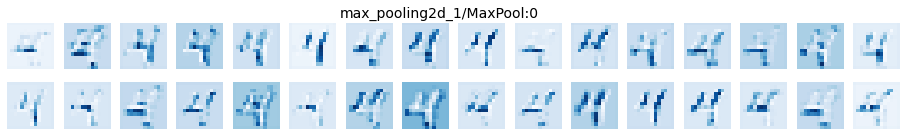

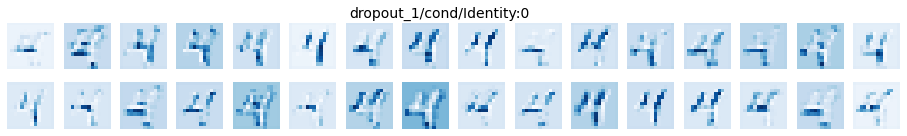

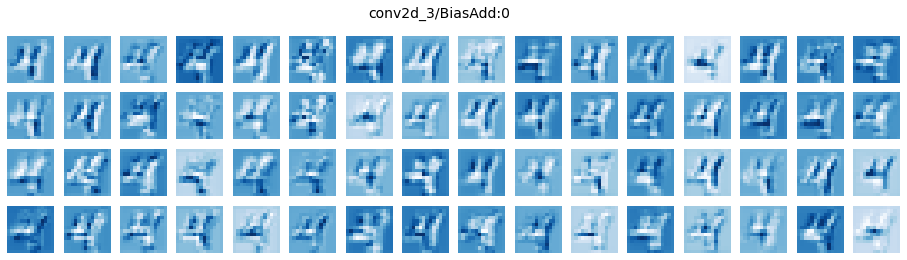

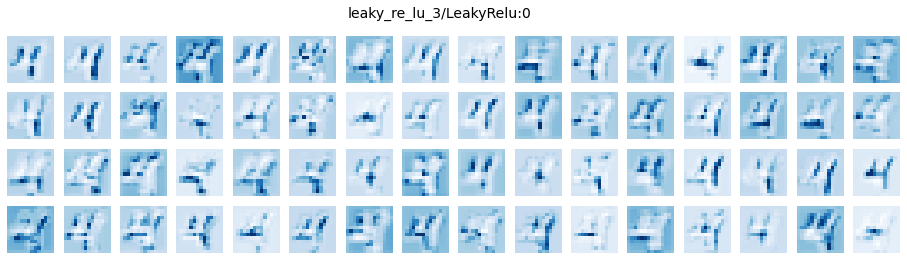

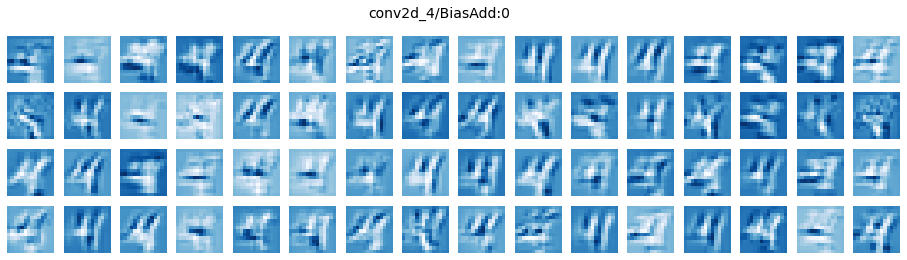

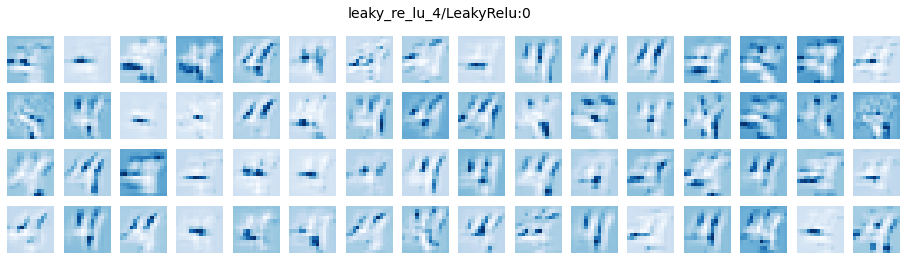

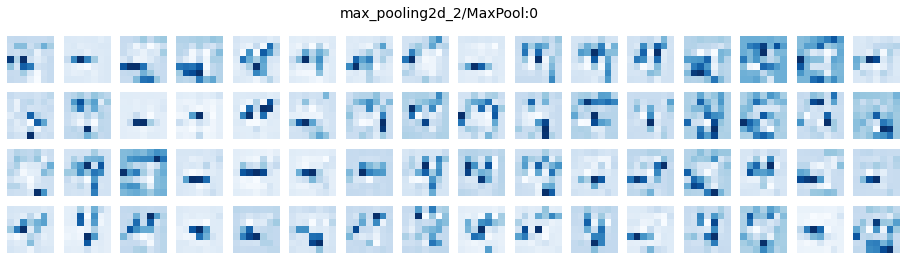

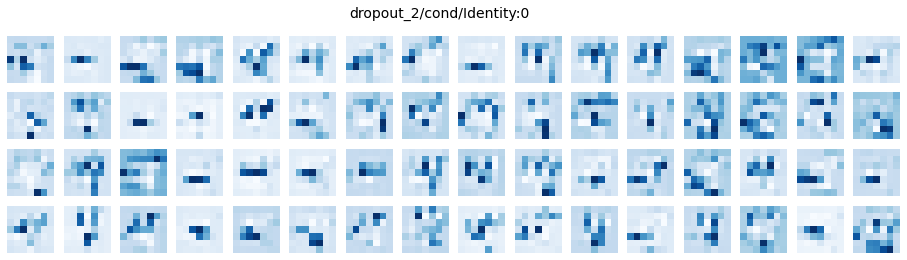

In [35]:
# Visualising each layers
for i,layer in enumerate(activation_model.predict(val_x[6].reshape([1,28,28,1]))):
    plot_layer(layer,i,output_layers[i].name)

In [36]:
df_submission = pd.DataFrame([df_test.index+1,test_y],["ImageId","Label"]).transpose()
df_submission.to_csv("submission.csv",index=False)

In [ ]:
print("d")